# Callback para medir la eficiencia del modelo

Vamos a trabajar con el mismo set de datos de main project

### Cargar datos con Keras Generator

Cargamos primeramente las librerias a utilizar

In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf

from tensorflow.keras import regularizers

# libreria para trabajar con las bases de datos 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

guardamos las rutas donde se encuentran los archivos en variables

In [3]:
train_dir = './sign-language-img/Train'
test_dir = './sign-language-img/Test'

- Generamos los data generator.

- Reescalamos los datos.

- Dividimos 20% de los datos de prueba a validacion

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

Creamos los generator para test, train y validacion

In [5]:
# para datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

# para daros de validacion
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

# para daros de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


Obtenemos las clases sin incluir la J y la Z

In [6]:
classes = [char for char in string.ascii_uppercase if char != 'J' if char != 'Z']
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

Creamos una funcion que muestre las imagenes pasadas en un array en grupos de 5

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Generamos un con conjunto de 5 imagenes

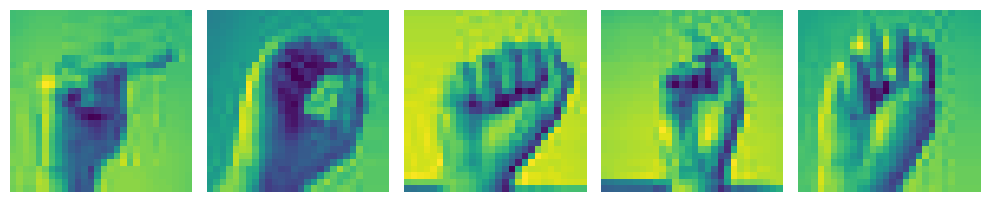

In [8]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

### Creacion del modelo y obtencion de las metricas de rendimiento

Vamos a recrear el ultimo modelo utilizado en main project

In [11]:
model_callback = tf.keras.Sequential([
    tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, kernel_regularizer = regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model_callback.summary()

2024-11-05 09:01:38.375905: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12675)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,245,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281,798 (12.52 MB)

 Trainable params: 3,281,798 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model_callback.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

Crearemos nuestro propio callback desde la clase Callback que nos ofrece Keras.

Podemos activar un callback en cualquier momento del ciclo de vida del modelo, para esta ocasión podemos elegir si activarlo al inicio de cada época, durante el entrenamiento o al final, para esta ocasión elegiremos el último caso.

Crearemos nuestra clase TrainingCallback que heredará de Callback, definiremos la función on_epoch_end que se activará cada que termine una época y recibirá como parámetros el objeto mismo, la época y los logs (que contendrán las métricas de la red).

Obtenemos la precisión de los logs y la comparamos, para esta ocasión determinaremos que el modelo se detenga si es mayor a 95% o 0.95, si es así, entonces daremos un pequeño mensaje pantalla y setearemos la variable self.model.stop_training en verdadero para detenerlo prematuramente.

In [13]:
# importamos el metodo callback
from tensorflow.keras.callbacks import Callback

In [14]:
# Clase trainingCallback

class TrainingCallback(Callback):
    
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') > 0.95:
            print('Logrado!. El modelo llego al 95%. Detenemos entrenamiento')
            self.model.stop_training = True

Para hacer efectivo este callback, creamos una instancia y lo inyectamos al momento de entrenar el modelo en el parámetro de callbacks, puedes notar que recibe una lista, por lo que puedes agregar cuantos quieras.

In [15]:
callBack = TrainingCallback()

Iniciamos el entrenamiento y al cumplirse la condicion el entrenamiento se detendra prematuramente

In [16]:
history_callback = model_callback.fit(
    train_generator, 
    epochs=20, 
    callbacks=[callBack],
    validation_data = validation_generator
    )

/home/jbernal/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 79s 325ms/step - accuracy: 0.2629 - loss: 2.4876 - val_accuracy: 0.7249 - val_loss: 0.8463
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 50s 230ms/step - accuracy: 0.8546 - loss: 0.4724 - val_accuracy: 0.8189 - val_loss: 0.6122
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9609 - loss: 0.1615Logrado!. El modelo llego al 95%. Detenemos entrenamiento
215/215 ━━━━━━━━━━━━━━━━━━━━ 49s 228ms/step - accuracy: 0.9609 - loss: 0.1614 - val_accuracy: 0.8112 - val_loss: 0.7112


### Personalizando Callbacks 

Puedes personalizar tus propios callbacks que podrás usar en diferentes etapas (entrenamiento, testing y predicción)

__Callback en el training__

In [17]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
  def on_train_begin(self, logs=None):
    print('Iniciando entrenamiento....')

  def on_epoch_begin(self, epoch, logs=None):
    print('Iniciando epoca {}'.format(epoch))
  
  def on_train_batch_begin(self, batch, logs=None):
    print('Entrenamiento: Iniciando batch {}'.format(batch))
  
  def on_train_batch_end(self, batch, logs=None):
    print('Entrenamiento: batch finalizado {}'.format(batch))

  def on_epoch_end(self, epoch, logs=None):
    print('Epoca finalizada {}'.format(epoch))

  def on_train_end(self, logs=None):
     print('Entrenamiento Finalizado!')


__Callback en el testing__

In [18]:
class TestingCallback(Callback):
  def on_test_begin(self, logs=None):
    print('Iniciando prueba....')
 
  def on_test_batch_begin(self, batch, logs=None):
    print('Prueba: Iniciando batch {}'.format(batch))
  
  def on_test_batch_end(self, batch, logs=None):
    print('Prueba: batch finalizado {}'.format(batch))

  def on_test_end(self, logs=None):
     print('Prueba finalizada!')


__Callback en prediction__

In [19]:
class PredictionCallback(Callback):
  def on_predict_begin(self, logs=None):
    print('Probando prediccion....')
 
  def on_predict_batch_begin(self, batch, logs=None):
    print('Prediccion: Iniciando batch {}'.format(batch))
  
  def on_predict_batch_end(self, batch, logs=None):
    print('Prediccion: batch finalizado {}'.format(batch))

  def on_predict_end(self, logs=None):
     print('Prediccion finalizada!')

### Como Utilizarlos?

In [20]:
# TRAINING
#model.fit(train_data, train_target, verbose = False, callbacks= [TrainingCallback()])

# TESTING
#model.evaluate(test_data, test_target, verbose = False, callbacks=[TestingCallback()])

# PREDICTION
#model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

### Recursos relevantes sobre Callbacks

* https://keras.io/callbacks/
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/CSVLogger
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LambdaCallback